### Explore Xsum

In [2]:
import os
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [3]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from dataset import Dataset
from torch.utils.data import DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, BartTokenizer, BartForConditionalGeneration, T5Config,BartConfig
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [7]:
model = "t5-small" #"bart-base"
dataset = "xsum"
path = f"{model}_{dataset}_nomask/outputs_{model}_{dataset}/model_files/"

In [8]:
# Load dataset
data = 'xsum'
model = "t5-small" #"bart-base"
if data == 'cnn_dailymail':
    dataset = load_dataset(data, '3.0.0')
    source_text = "article"
    target_text = "highlights"
elif data == "xsum":
    dataset = load_dataset(data)
    source_text = "document"
    target_text = "summary"
else:
    raise ValueError("Undefined dataset")
    
model_params = {
    "MODEL": model,  # model_type: t5-base/t5-large
    "BATCH_SIZE": 1024,  # training batch size
    "MAX_SOURCE_TEXT_LENGTH": 512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH": 36,  # max length of target text
    "SEED": 42,  # set seed for reproducibility
}

val_dataset = dataset["validation"]
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print("Total training set len: ", len(val_dataset))

if "bart" in model:
    tokenizer = BartTokenizer.from_pretrained(path)
elif "t5" in model:
    tokenizer = T5Tokenizer.from_pretrained(path)# just because our Dataset requires it
else:
    pass

train_set = Dataset(
    train_dataset,
    tokenizer,
    model_params["MODEL"],
    model_params["MAX_SOURCE_TEXT_LENGTH"],
    model_params["MAX_TARGET_TEXT_LENGTH"],
    source_text,
    target_text,
)

val_set = Dataset(
    val_dataset,
    tokenizer,
    model_params["MODEL"],
    model_params["MAX_SOURCE_TEXT_LENGTH"],
    model_params["MAX_TARGET_TEXT_LENGTH"],
    source_text,
    target_text,
)

test_set = Dataset(
    test_dataset,
    tokenizer,
    model_params["MODEL"],
    model_params["MAX_SOURCE_TEXT_LENGTH"],
    model_params["MAX_TARGET_TEXT_LENGTH"],
    source_text,
    target_text,
)
print("Final data top q1 set len: ", len(train_set))
print("Final data top q3 set len: ", len(val_set))

Using custom data configuration default
Reusing dataset xsum (/home/pranisaa/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

Total training set len:  11332
Final data top q1 set len:  204045
Final data top q3 set len:  11332


In [9]:
params = {
    "batch_size": model_params["BATCH_SIZE"],
    "shuffle": False,
    "num_workers": 0,
}
train_loader = DataLoader(train_set, **params)
val_loader = DataLoader(val_set, **params)
test_loader = DataLoader(test_set, **params)

In [11]:
train_len = []
for _, data in enumerate(train_loader, 0):
    print(_,"/",len(train_loader))
    len_check = data["source_len"]
    train_len.extend(len_check.tolist())

In [26]:
import pickle

# To write
# with open("train_len", "wb") as fp:   #Pickling
#     pickle.dump(train_len, fp)
    
with open('train_len', 'rb') as handle:
    train_len = pickle.load(handle)

Text(0.5, 1.0, 'Histogram of source lengths')

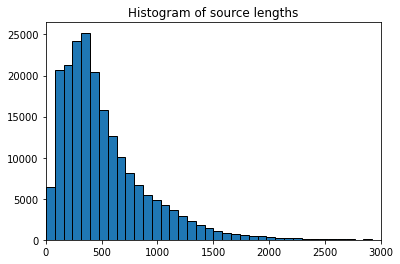

In [17]:
# matplotlib histogram
plt.hist(train_len, edgecolor = 'black',
         bins = 500)
plt.xlim([0,3000])
plt.title(f'Histogram of source lengths')

In [107]:
# train_len = np.array(train_len)
# print(len(train_len[train_len<512])/len(train_len))

0.6158641476144968


In [91]:
val_len = []
for _, data in enumerate(val_loader, 0):
    print(_,"/",len(val_loader))
    len_check = data["source_len"]
    val_len.extend(len_check.tolist())

0 / 12
1 / 12
2 / 12
3 / 12
4 / 12
5 / 12
6 / 12
7 / 12
8 / 12
9 / 12
10 / 12
11 / 12


In [25]:
import pickle

# To WRITE
# with open("val_len", "wb") as fp:   #Pickling
#     pickle.dump(val_len, fp)

# To READ
with open('val_len', 'rb') as handle:
    val_len = pickle.load(handle)


7730
3


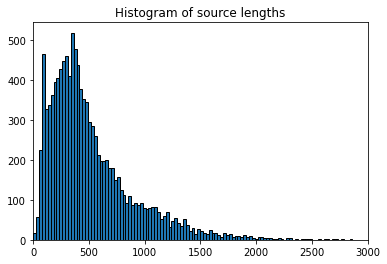

In [19]:
plt.hist(val_len, edgecolor = 'black',
         bins = 300)

plt.title(f'Histogram of source lengths')
plt.xlim([0,3000])
print(max(val_len))
print(min(val_len))

In [87]:
test_len = []
for _, data in enumerate(test_loader, 0):
    print(_,"/",len(test_loader))
    len_check = data["source_len"]
    test_len.extend(len_check.tolist())

0 / 12
1 / 12
2 / 12
3 / 12
4 / 12
5 / 12
6 / 12
7 / 12
8 / 12
9 / 12
10 / 12
11 / 12


In [24]:
# To WRITE
# with open("test_len", "wb") as fp:   #Pickling
#     pickle.dump(test_len, fp)

# To READ
with open('test_len', 'rb') as handle:
    test_len = pickle.load(handle)

15861
3


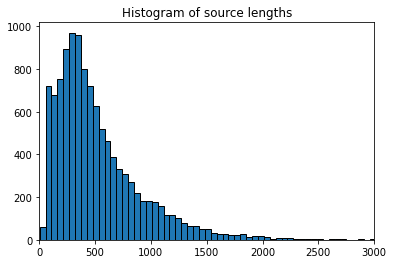

In [22]:
plt.hist(test_len, edgecolor = 'black',
         bins = 300)

plt.title(f'Histogram of source lengths')
plt.xlim([0,3000])
print(max(test_len))
print(min(test_len))

In [28]:
total = []
total.extend(train_len)
total.extend(val_len)
total.extend(test_len)

In [29]:
print("MEAN of TOTAL: ", np.mean(total))
print("MEAN of TRAIN: ", np.mean(train_len))
print("MEAN of VAL: ", np.mean(val_len))
print("MEAN of TEST: ", np.mean(test_len))
train_len = np.array(train_len)
val_len = np.array(val_len)
test_len = np.array(test_len)
print("PERCENT OF TRAIN < 512: ", len(train_len[train_len<512])/len(train_len))
print("PERCENT OF VAL < 512: ", len(val_len[val_len<512])/len(val_len))
print("PERCENT OF TEST < 512: ", len(test_len[test_len<512])/len(test_len))

MEAN of TOTAL:  525.6879551499486
MEAN of TRAIN:  525.9222328407949
MEAN of VAL:  518.6749911754324
MEAN of TEST:  528.4820010587613
PERCENT OF TRAIN < 512:  0.6158641476144968
PERCENT OF VAL < 512:  0.6236321920225909
PERCENT OF TEST < 512:  0.6131109934709723
